Update Complete


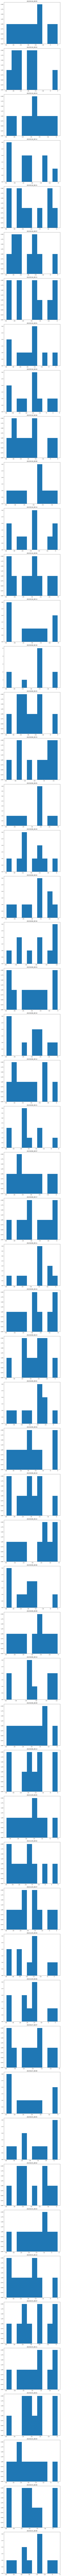

In [6]:
import os
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import chi2
import json
import sys
import math
import matplotlib.pyplot as plt

# Load the DB file
# df_db : Data frame of accumulated Experimental result information - Abundance
path_db = os.path.abspath('') + "/input/db_abundance.csv"
df_db = pd.read_csv(path_db)

# Load the Experiment result file
# df_exp : Data frame of Experimental result information - Abundance
path_exp = os.path.abspath('') + "/input/experiment_result_abundance.csv"
df_exp = pd.read_csv(path_exp)

# Load the merged Valencia output file
# df_valencia : Data frame of merged Valencia output
path_valencia = os.path.abspath('') + "/input/VALENCIA_output_merged.csv"
df_valencia = pd.read_csv(path_valencia)

# Insert data into DB - Merge the data frame df_db & df_exp

try: 
    df_db = pd.merge(df_db, df_exp, how='outer',on='taxa', suffixes=['', '_right']) 
    df_db = df_db.fillna(0)
    df_db = df_db.filter(regex='^(?!.*_right).*') # Eliminate duplicate columns

    # Update the statistic - <<Uncomment only when updating json_grs_statistics.json>>     
    df_exp = df_db

    df_db_rev = df_db.set_index(keys=['taxa'], inplace=False, drop=True)    
    df_db_rev.to_csv(path_db)
    
except:
    print("Check the Experiment result file")
    sys.exit()
    
# Delete the diversity, observed rows
if (list(df_exp['taxa'][0:2]) == ['diversity', 'observed']) & (list(df_db['taxa'][0:2]) == ['diversity', 'observed']):
    df_exp = df_exp.iloc[2:,:]
    df_db = df_db.iloc[2:,:]
else:
    print("Check the diversity & observed rows in the exp file or db file")
    sys.exit()


# Load the Phenotype-Microbiome file
# df_beta : Data frame of of Phenotype-Microbiome information
path_beta = os.path.abspath('') + "/input/phenotype_microbiome.xlsx"
df_beta = pd.read_excel(path_beta)
df_beta.rename(columns = {"Disease": "phenotype", "NCBI name": "ncbi_name", "MIrROR name": "microbiome", "Health sign": "beta", "subtract": "microbiome_subtract"}, inplace=True)
df_beta = df_beta[["phenotype", "ncbi_name", "microbiome", "beta","microbiome_subtract"]]
df_beta['beta'] = df_beta['beta'].replace({'증가': 1, '감소': -1})

li_new_sample_name = list(df_exp.columns)[1:]  
li_phenotype = list(dict.fromkeys(df_beta['phenotype']))

# Subtract the abundance - df_exp

for idx_beta, row_beta in df_beta.iterrows(): 
    li_micro_sub = []

    if pd.isna(row_beta['microbiome_subtract']) is False:
        li_micro_sub = row_beta['microbiome_subtract'].split('\n')
        
        for micro_sub in li_micro_sub:
            condition = (df_exp.taxa == row_beta['microbiome'])
            condition_sub = (df_exp.taxa == micro_sub)
            
            if len(df_exp[condition_sub]) > 0:
                
                for sample_name in li_new_sample_name:
                    df_exp.loc[condition, sample_name] -= df_exp[condition_sub][sample_name].values[0]

# Calculate the GRS 
# li_phenotype : Phenotype list 
# df_grs : Data frame of grs corresponding to specific phenotype and sample

df_grs = pd.DataFrame(index = li_new_sample_name, columns = li_phenotype)
df_grs = df_grs.fillna(0) 

for i in range(len(li_new_sample_name)):
    for j in range(len(li_phenotype)):
        condition_phen = (df_beta.phenotype == li_phenotype[j])   
        grs = 0
        
        for idx_beta, row_beta in df_beta[condition_phen].iterrows():
            condition_micro = (df_exp.taxa == row_beta['microbiome'])
            
            if (len(df_exp[condition_micro]) > 0):      
                x_i = df_exp[condition_micro][li_new_sample_name[i]].values[0]
                ln_x_i = math.log(x_i + 1e-15)  
                grs += ln_x_i * row_beta['beta']
            
            elif (len(df_exp[condition_micro]) == 0):      
                x_i = 0
                ln_x_i = math.log(x_i + 1e-15)  
                grs += ln_x_i * row_beta['beta']                
            
        grs /= len(df_beta[condition_phen])       
        df_grs.loc[li_new_sample_name[i], li_phenotype[j]] = grs

# Save the grs data      
path_grs = os.path.abspath('') + "/input/vaginal_grs.xlsx"        
df_grs.to_excel(path_grs)

# Histogram Plot - GRS - <<Uncomment only when updating json_grs_statistics.json>>
def save_histograms_to_file(df, filename):
    num_rows = df.shape[0]
    fig, axs = plt.subplots(num_rows, 1, figsize=(8, 6*num_rows))
    
    for i in range(num_rows):
        axs[i].hist(df.iloc[i,:], bins=10)
        axs[i].set_title(df.index.to_list()[i])
    
    plt.tight_layout()
    plt.savefig(filename)
    
save_histograms_to_file(df_grs, '/home/kbkim/vaginal_microbiome/output/grs_hist.png')    

print('Update Complete')       
     
        
        
        
        
        
        
        